# Red Neuronal Conditional GAN

Autor: M. en C. Mario Xavier Canche Uc, Diciembre 2020, mario.canche@cimat.mx  

Basado en: 
- https://www.cimat.mx/~mrivera/cursos/aprendizaje_profundo/dcgan/dcgan.html  
- https://www.tensorflow.org/tutorials/generative/dcgan

## Cargamos las librerías

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def reset_weights(model):
    '''
    Reinicializa los pesos del modelo 
    '''
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and \
                hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer   = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer  (shape  =len(old_biases))])


## Definimos los paramétros

In [ ]:
# carga datos reales     
(X_train, y_train), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)

In [ ]:
(buffer_size,img_rows, img_cols, channels) = X_train.shape
img_shape  = (img_rows, img_cols, channels)
z_dim      = 20     # dimensión del espacio latente
batch_size = 256
num_epochs = 100
each_save  = 5

path_results = 'dcgan_results/'

In [ ]:
%mkdir dcgan_results/

mkdir: cannot create directory ‘dcgan_results/’: File exists


In [ ]:
%ls

dcgan_results/  R_UNET.h5  sample_data/


In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size).batch(batch_size)
train_dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None, 1)), types: (tf.float64, tf.uint8)>

## Definimos el Generador

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Input, Embedding, multiply, Reshape

def build_generator(img_shape, z_dim, num_classes, verbose=False):
    '''
    Genera una imagen de 28x28x1 a partir de un vector aleatorio de 100 entradas (espacio latente)
    '''

    z = Input(shape=(z_dim,))
    # ---------------------------------------
    # Agregamos las etiquetas al generador
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, z_dim)(label))

    model_input = multiply([z, label_embedding])
    # ---------------------------------------

    # Pasa entrada unidimensional de dimensión 20 en un tensor de (7)(7)(256) tensor via un red Densa
    # luego la reformatea en un tensor de 7x7x128
    #X = Dense(256 * 7 * 7, input_dim=z_dim) (z)
    X = Dense(256 * 7 * 7, input_dim=z_dim) (model_input)

    X = Reshape((7, 7, 256))(X)

    # Convolución transpuesta, tensor de 7x7x256 a 14x14x128, con normalización por lote y activación ReLU
    X = Conv2DTranspose(filters    =128, 
                        kernel_size=3, 
                        strides    =2, 
                        padding    ='same')(X)

    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)
    
    # Convolución transpuesta, tensor de 14x14x128, a 14x14x64 con normalización por lote y activación ReLU
    X = Conv2DTranspose(filters    =64, 
                        kernel_size=3, 
                        strides    =1, 
                        padding    ='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha=0.01)(X)
    
    # Convolución transpuesta, tensor de 14x14x128 a 28x28x1, con activación tahn
    Y = Conv2DTranspose(filters    =1, 
                        kernel_size=3, 
                        strides    =2, 
                        padding    ='same',
                        activation ='tanh')(X)
    
    #generator_model = Model(inputs = z, outputs = [Y], name ='generator')
    generator_model = Model(inputs = [z, label], outputs = [Y], name ='generator')
    
    return generator_model

In [ ]:
num_classes = 10

generator = build_generator(img_shape, z_dim, num_classes)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 20)        200         input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 20)           0           embedding_2[0][0]                
__________________________________________________________________________________________

## Definimos el Discriminador

In [ ]:
def build_discriminator(img_shape, num_classes, verbose=False):

    Xin = Input(shape=(img_shape[0],img_shape[1],img_shape[2],))

    # ---------------------------------------
    # Agregamos las etiquetas al discriminador
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    label_reshape = Reshape((img_shape[0],img_shape[1],img_shape[2]))(label_embedding)

    model_input = multiply([Xin, label_reshape])
    # ---------------------------------------


    # Convolución2D tensor de 28x28x1 a 14x14x32 y activación Leaky ReLU
    X = Conv2D(filters     = 32, 
               kernel_size = 3, 
               strides     = 2, 
               input_shape = img_shape, 
               #padding     = 'same')(Xin)
               padding     = 'same')(model_input)
    #X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    # Convolución2D tensor de 14x14x32 a 7x7x64, con normalización por lote y activación Leaky ReLU
    X = Conv2D(filters     = 64, 
               kernel_size = 3, 
               strides     = 2, 
               padding     = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)
    
    # Convolución2D tensor de 7x7x64 a 3x3x128, con normalización por lote y activación Leaky ReLU
    X = Conv2D(filters     = 128, 
               kernel_size = 3, 
               strides     = 2,  
               padding     = 'same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha    = 0.01)(X)

    # Aplanado del tensor, y capa densa de salida de clasificacion con activación sigmoide
    X = Flatten()(X)
    Yout = Dense(1, activation='sigmoid')(X)

    #discriminator_model = Model(inputs = Xin, outputs = [Yout], name ='discriminator')
    discriminator_model = Model(inputs = [Xin,label], outputs = [Yout], name ='discriminator')

    return discriminator_model

In [ ]:
# construye el discriminador 
discriminator = build_discriminator(img_shape, num_classes)
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 784)       7840        input_8[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 784)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

## Definimos las funciones de pérdida

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida del discriminador

In [ ]:
def discriminator_loss_classic(real_output, fake_output):
    # pérdida de los verdaeros (1 vs y_hat )
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # pérdida de los sintéticos (0 vs y_hat )
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # suma de los dos tipos de errores
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_loss(real_output, fake_output):
    # pérdida de los verdaeros (1 vs y_hat )   + pérdida de los sintéticos (0 vs y_hat 
    total_loss = -tf.reduce_mean(tf.keras.backend.log(real_output) + tf.keras.backend.log(1.- fake_output))
    return total_loss

### Pérdida del generador

In [ ]:
def generator_loss_classic(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def generator_loss(real_output,fake_output):
    #  pérdida de los sintéticos (0 vs y_hat 
    total_loss = -tf.reduce_mean(tf.keras.backend.log(fake_output))
    return total_loss

## Definimos los optimizadores

In [ ]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

## Definimos los pasos para el Entrenamiento

In [ ]:
#El decorador `tf.function` indica que la función se "compila" para que pueda incluirse en un gráfo de calculo.

@tf.function
def train_step(images, labels):
    '''
    
    Implementa un paso de entrenamiento para la GAN
    
    Recibe como parámetros un semi-lote de imágenes reales
    '''

    # variables latentes (ruido Gaussiano), tantas como imagenes reales
    z = tf.random.normal([images.shape[0], z_dim])
    #z_labels = np.random.randint(0, 10, images.shape[0]).reshape(-1, 1)

    # Los siguientes pasos registaran (en "TAPE") para efectos de calcular gradientes
    # son dos "Tapes" para registrar los calculos de cada modelo
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # genera el semi-lote de datos sintéticos
        #generated_images = generator(z, training=True)
        generated_images = generator([z, labels], training=True)
        #generated_images = generator([z, z_labels], training=True)
        
        # calcula la predicción para datos verdaderos y falsos
        #real_output = discriminator(images, training=True)
        #fake_output = discriminator(generated_images, training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        # calcula las pérdidas del Discriminador y del Generador
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss  = generator_loss(real_output, fake_output)

    # Para cada modelo, calcula el gradiente de su función de costo respecto a sus pesos entrenables, 
    # haciendo retropropagación sobre los calculos realizados
    gradients_of_generator     = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Hace el paso de actualizacion de los pesos
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
from tensorflow.keras.models import load_model

# Cargamos el Modelo pre-entrenado de Super-Resolucion con UNET
model_R_UNET = load_model("/content/R_UNET.h5")

In [ ]:
from PIL import Image
import imageio
import glob

# - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Crea una collage de imágenes con el Generador y la guarda
# - - - - - - - - - - - - - - - - - - - - - - - - - - 

num_examples_to_generate = 16 # (4,4)
seed = tf.random.normal([num_examples_to_generate, z_dim])
#seed_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
seed_labels = np.random.randint(0, 10, num_examples_to_generate).reshape(-1, 1)

def generate_and_save_images(model, epoch, test_input, test_labels, runet=False, pathdir=path_results):
    # Se pone entrenable en Falso porque esta en modo inferencia el 
    predictions = model([test_input, test_labels], training=False)* 127.5 + 127.5

    if runet:
      # Aplicamos la super resolution a las imagenes
      predictions = model_R_UNET.predict(predictions)

    fig = plt.figure(figsize=(4,4))  

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        #plt.axis('off')

    plt.savefig(pathdir+'image_epch_{:04d}.png'.format(epoch))
    plt.show()
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Despliega la imagen correspondiente a una época
# - - - - - - - - - - - - - - - - - - - - - - - - - - 

def display_image(epoch_no, pathdir=path_results):
    return Image.open(pathdir+'image_epch_{:04d}.png'.format(epoch_no))

In [ ]:
from IPython import display
import time 

def train(dataset, epochs):
    
    generator_losses=[] 
    discriminator_losses=[]
    for epoch in range(epochs):
        start = time.time()

        for image_batch, labels in dataset:
            gen_loss, disc_loss = train_step(image_batch,labels)
        
        # solo registramos los costos en el último lote
        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)
        
        
        # Produce imágenes para crear el GIF
        if (epoch+1)%each_save ==0:
            #display.clear_output(wait=True)  # limpia el buffer
            generate_and_save_images(generator,
                                     epoch + 1,
                                     seed,
                                     seed_labels)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Genera las las imágens correspondientes a la época final
    #display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               seed_labels)

    return np.array(generator_losses), np.array(discriminator_losses)

## Entrenamos la GAN

Time for epoch 1 is 20.90444850921631 sec
Time for epoch 2 is 18.17378330230713 sec
Time for epoch 3 is 18.191296577453613 sec
Time for epoch 4 is 17.93563151359558 sec


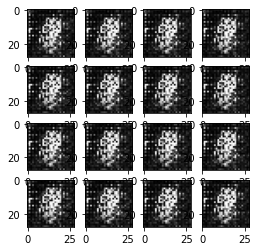

Time for epoch 5 is 20.715033054351807 sec
Time for epoch 6 is 18.072904586791992 sec
Time for epoch 7 is 18.208279371261597 sec
Time for epoch 8 is 18.012154579162598 sec
Time for epoch 9 is 18.206514358520508 sec


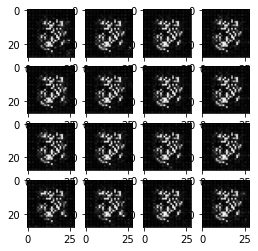

Time for epoch 10 is 20.39849829673767 sec
Time for epoch 11 is 18.123301029205322 sec
Time for epoch 12 is 18.201714515686035 sec
Time for epoch 13 is 18.036454439163208 sec
Time for epoch 14 is 18.156790733337402 sec


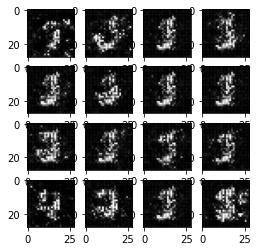

Time for epoch 15 is 20.374117136001587 sec
Time for epoch 16 is 18.18848156929016 sec
Time for epoch 17 is 18.091473817825317 sec
Time for epoch 18 is 18.159412145614624 sec
Time for epoch 19 is 18.14753818511963 sec


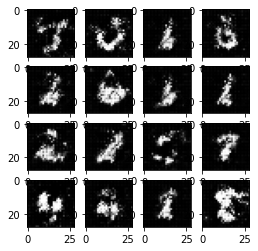

Time for epoch 20 is 20.387486457824707 sec
Time for epoch 21 is 18.15192413330078 sec
Time for epoch 22 is 17.942599773406982 sec
Time for epoch 23 is 18.078360319137573 sec
Time for epoch 24 is 18.10347580909729 sec


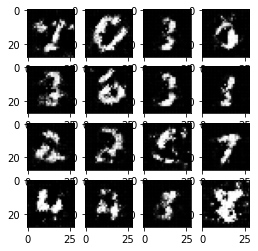

Time for epoch 25 is 20.351178407669067 sec
Time for epoch 26 is 18.242193698883057 sec
Time for epoch 27 is 18.0507390499115 sec
Time for epoch 28 is 18.09778904914856 sec
Time for epoch 29 is 18.040136575698853 sec


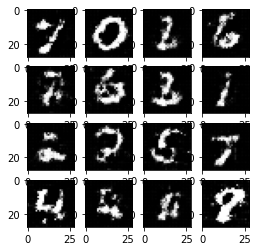

Time for epoch 30 is 20.63101553916931 sec
Time for epoch 31 is 18.096344709396362 sec
Time for epoch 32 is 18.129900455474854 sec
Time for epoch 33 is 18.035322666168213 sec
Time for epoch 34 is 18.0744411945343 sec


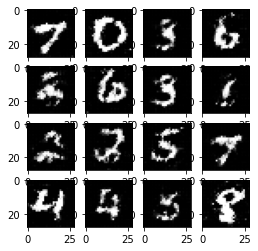

Time for epoch 35 is 20.383109092712402 sec
Time for epoch 36 is 18.23036551475525 sec
Time for epoch 37 is 18.07129168510437 sec
Time for epoch 38 is 18.03504776954651 sec
Time for epoch 39 is 18.07952356338501 sec


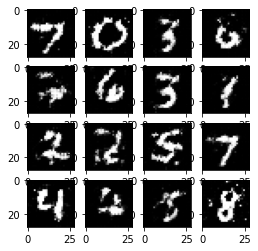

Time for epoch 40 is 20.42123246192932 sec
Time for epoch 41 is 18.081442832946777 sec
Time for epoch 42 is 18.063202619552612 sec
Time for epoch 43 is 18.037493467330933 sec
Time for epoch 44 is 17.949936151504517 sec


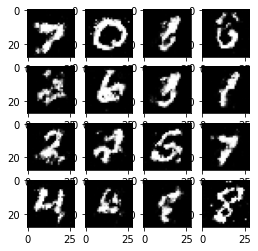

Time for epoch 45 is 20.64345145225525 sec
Time for epoch 46 is 18.34088706970215 sec
Time for epoch 47 is 18.172311782836914 sec
Time for epoch 48 is 18.089019775390625 sec
Time for epoch 49 is 18.250231504440308 sec


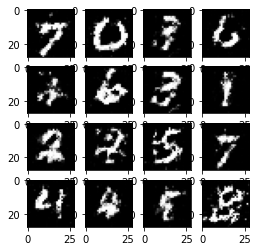

Time for epoch 50 is 20.588201999664307 sec
Time for epoch 51 is 18.418164253234863 sec
Time for epoch 52 is 18.1731436252594 sec
Time for epoch 53 is 18.400988817214966 sec
Time for epoch 54 is 18.172597885131836 sec


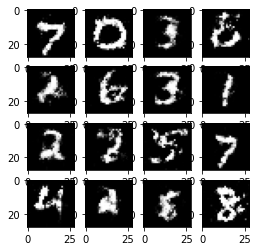

Time for epoch 55 is 20.550789833068848 sec
Time for epoch 56 is 18.235296964645386 sec
Time for epoch 57 is 18.303170442581177 sec
Time for epoch 58 is 18.234133005142212 sec
Time for epoch 59 is 18.22459053993225 sec


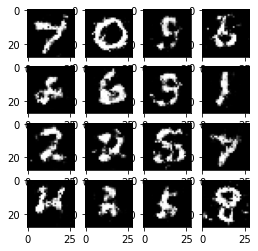

Time for epoch 60 is 20.78556799888611 sec
Time for epoch 61 is 18.204113960266113 sec
Time for epoch 62 is 18.348499298095703 sec
Time for epoch 63 is 18.252333879470825 sec
Time for epoch 64 is 18.13692569732666 sec


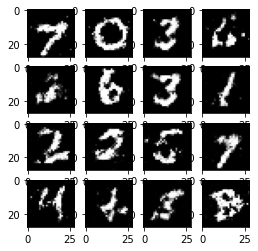

Time for epoch 65 is 20.734403133392334 sec
Time for epoch 66 is 18.23301887512207 sec
Time for epoch 67 is 18.22025179862976 sec
Time for epoch 68 is 18.290449619293213 sec
Time for epoch 69 is 18.294816732406616 sec


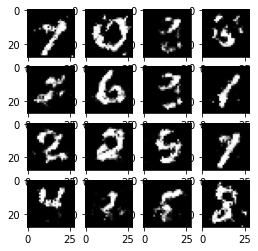

Time for epoch 70 is 20.464038848876953 sec
Time for epoch 71 is 18.194456577301025 sec
Time for epoch 72 is 18.350285053253174 sec
Time for epoch 73 is 18.177180290222168 sec
Time for epoch 74 is 18.183228969573975 sec


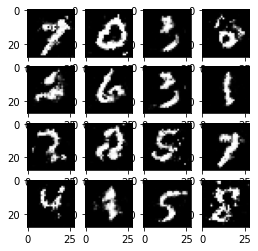

Time for epoch 75 is 20.71501135826111 sec
Time for epoch 76 is 18.329076528549194 sec
Time for epoch 77 is 18.211803913116455 sec
Time for epoch 78 is 18.253904342651367 sec
Time for epoch 79 is 18.12955331802368 sec


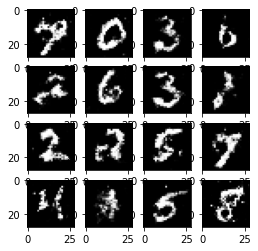

Time for epoch 80 is 20.607682704925537 sec
Time for epoch 81 is 18.215238094329834 sec
Time for epoch 82 is 18.176449298858643 sec
Time for epoch 83 is 18.144792556762695 sec
Time for epoch 84 is 18.159214735031128 sec


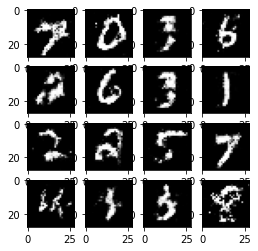

Time for epoch 85 is 20.599581241607666 sec
Time for epoch 86 is 18.19150185585022 sec
Time for epoch 87 is 18.310035705566406 sec
Time for epoch 88 is 18.1056489944458 sec
Time for epoch 89 is 18.196803331375122 sec


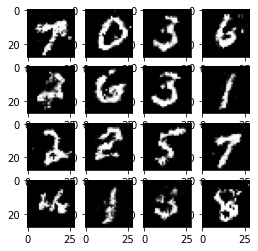

Time for epoch 90 is 20.7365083694458 sec
Time for epoch 91 is 18.365889310836792 sec
Time for epoch 92 is 18.03159809112549 sec
Time for epoch 93 is 18.338997840881348 sec
Time for epoch 94 is 18.1503803730011 sec


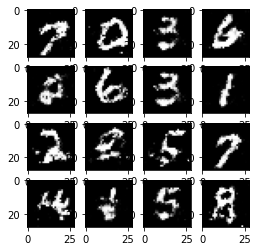

Time for epoch 95 is 20.484991550445557 sec
Time for epoch 96 is 18.341567993164062 sec
Time for epoch 97 is 18.166603803634644 sec
Time for epoch 98 is 18.200507640838623 sec
Time for epoch 99 is 18.09718418121338 sec


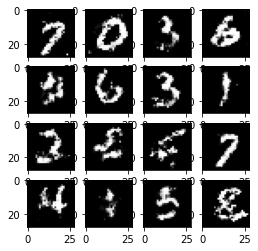

Time for epoch 100 is 20.503328561782837 sec


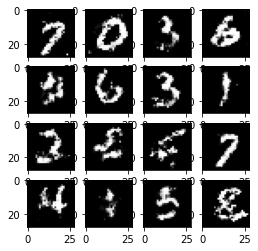

In [ ]:
generator_losses, discriminator_losses = train(train_dataset, num_epochs)

## Guardamos los resultados

In [ ]:
generator.save_weights('dcgan_generator_0_1.h5')
discriminator.save_weights('dcgan_discriminator_0_1.h5')

## Visualizamos los resultados

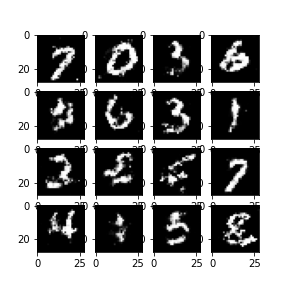

In [ ]:
display_image(num_epochs)

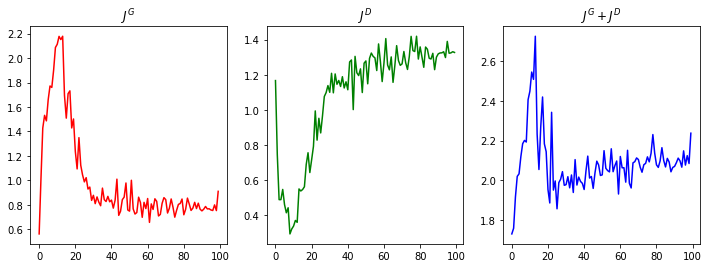

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(generator_losses, 'r')
plt.title('$J^G$')
plt.subplot(132)
plt.plot(discriminator_losses, 'g')
plt.title('$J^D$')
plt.subplot(133)
plt.plot(generator_losses+discriminator_losses, 'b')
plt.title('$J^G+J^D$')
plt.show()

## Ejemplo de Digitos generados y aplicando la SuperResolucion UNET

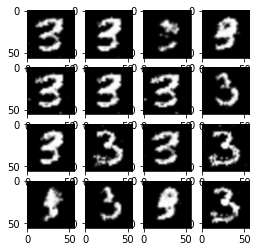

In [ ]:
# Generamos el digito 3
digito = 3
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)

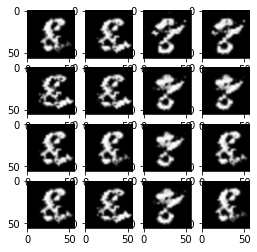

In [ ]:
# Generamos el digito 8
digito = 8
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)

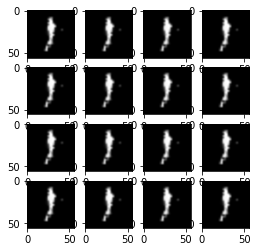

In [ ]:
# Generamos el digito 1
digito = 1
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)

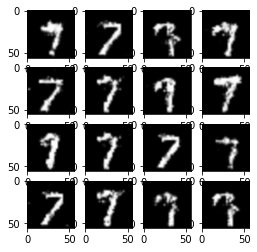

In [ ]:
# Generamos el digito 7
digito = 7
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)

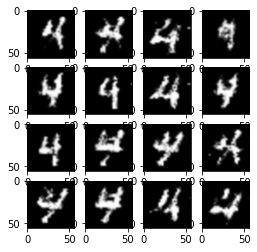

In [ ]:
# Generamos el digito 4
digito = 4
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)

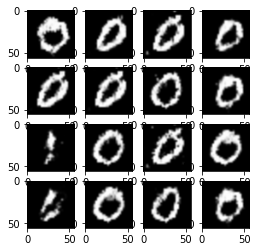

In [ ]:
# Generamos el digito 0
digito = 0
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)

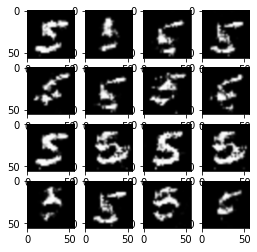

In [ ]:
# Generamos el digito 5
digito = 5
seed_digito = np.random.randint(digito, digito+1, num_examples_to_generate).reshape(-1, 1)
generate_and_save_images(generator,0,seed, seed_digito, runet=True)